In [135]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import json
import nltk
import wordcloud
import spacy

In [18]:
df = pd.read_json("../data/epirecipes/full_format_recipes.json")
df.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [19]:
print(f"Number of recipes before dropna: {len(df)}")
df.dropna(inplace=True, subset=["directions","ingredients"])
print(f"Number of recipes after dropna: {len(df)}")

Number of recipes before dropna: 20130
Number of recipes after dropna: 20111


## Ingredients

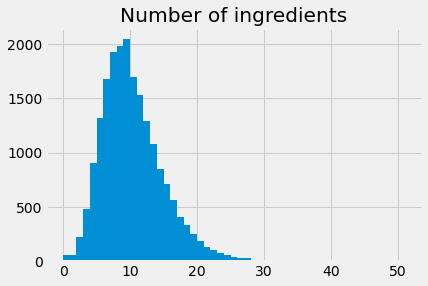

Median number of ingredients: 9.0
Std. deviation of number of ingredients: 4.60


In [136]:
def count_ingredients(ingredients):
    if isinstance(ingredients, list):
        return len(ingredients)
    else:
        return 0

df['n_ingredients'] = df.ingredients.apply(count_ingredients)

#plot distribution
plt.title("Number of ingredients")
plt.hist(df.n_ingredients.tolist(), bins=max(df.n_ingredients.tolist()))
plt.show()

print(f"Median number of ingredients: {df.n_ingredients.median()}")
print(f"Std. deviation of number of ingredients: {df.n_ingredients.std():.2f}")

The median number of ingredients is 9, which seems plausible. There are some recipes that require a lot of ingredients, i.e. the distribution is long tailed. However, the majority has 1-20 ingredients. There are some ingredients that require no ingredients (i.e. those are nan values or empty lists)

In [30]:
for i in range(10):
    recipe = df[df.n_ingredients == 0].iloc[i]
    print("{}: {}".format(recipe.title, len(recipe.directions)))

To Toast and Skin Hazelnuts : 2
To Toast Spices, Nuts, or Seeds : 3
Barley and Mushroom Pilaf : 0
Grilling Procedure : 6
Chicken Tarragon : 2
Boiling Water Bath for Jams, Chutneys, Pickles, and Salsas : 8
Asian Lamb Stir-Fry in Radicchio Wraps : 0
To Prepare a Water Bath for Baking : 1
Procedure for Shorter Time Processing : 5
Procedure for Longer Time Processing : 5


As one can see, many recipes with no ingredients are instructions for common task or general cooking skills, like grilling or preparing water baths.

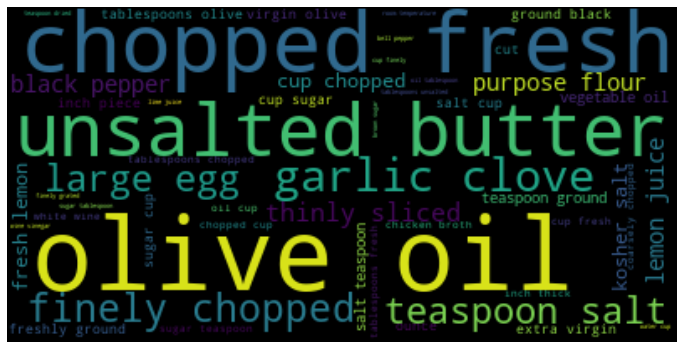

In [51]:
total_ingredients = nltk.flatten(df.ingredients.tolist())
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(total_ingredients))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

As one can see, olive oil is the most prominent ingredient. However, the ingredients include adjectives (chopped, fresh, unstalted, large etc.). This needs to be cleaned to obtain the real ingredients.

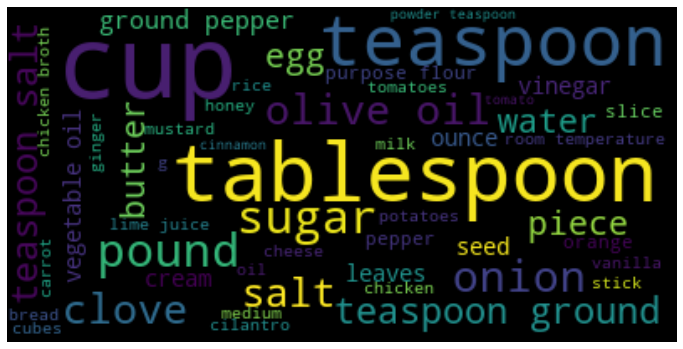

In [82]:
nlp = spacy.load("en_core_web_sm")
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if word.pos_ == "NOUN"]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

This looks better, but still cup is the most prominent word although it is a measure and not an ingredient. This probably has to be removed manually via a stopword list, tablespoon, teaspoon, pund, similarly. Interestingly words like vegetable are of course nouns but most likely appear in combination with stock for example where they are adjectives. This has to be taken care of. Why are lentils so prominent?

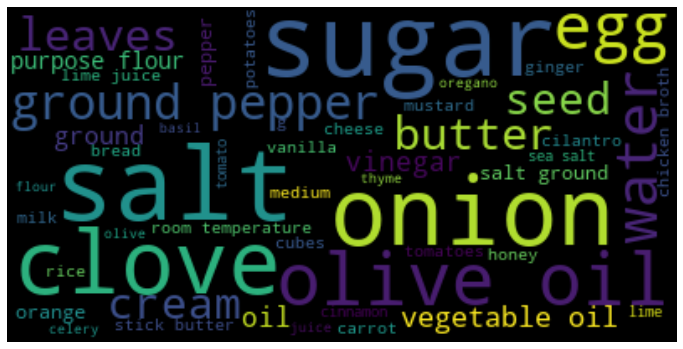

In [91]:
# without units (special stopwords)
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "ounce", "ounces","slice","slices", "piece", "pieces"}
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if (word.pos_ == "NOUN" and not word.is_stop)]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")


## Directions

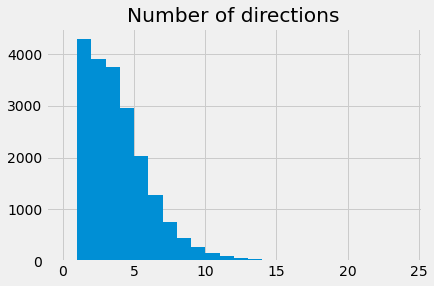

Median number of directions: 3.0
Std. deviation of number of directions: 2.34


In [137]:
def count_directions(directions):
    if isinstance(directions, list):
        return len(directions)
    else:
        return 0

df['n_directions'] = df.directions.apply(count_directions)

#plot distribution
plt.title("Number of directions")
plt.hist(df.n_directions.tolist(), bins=max(df.n_directions.tolist()))
plt.show()

print(f"Median number of directions: {df.n_directions.median()}")
print(f"Std. deviation of number of directions: {df.n_directions.std():.2f}")

Interestingly, ther are quite a lot of recipes with only a few directions (i.e. simple recipes). Only a samll number of recipes have more than 10 directions.

In [40]:
for i in range(10):
    recipe = df[df.n_directions == 0].iloc[i]
    print("{}: {}".format(recipe.title, len(recipe.ingredients)))

Mixed-Berry Daiquiri : 9
Barley and Mushroom Pilaf : 0
Old-Fashioned : 7
Asian Lamb Stir-Fry in Radicchio Wraps : 0
Mulled Cider : 8
Pineapple-Banana Smoothie : 5
Dragoon Punch : 8
Plum Glaze : 7
Plum Glaze : 7
Frozen Banana, Pineapple and Rum Cocktail : 8


While some recipes with no instructions also have no ingredients, there are some which should have instructions. Interesstingly, most of the recipes are for drinks.

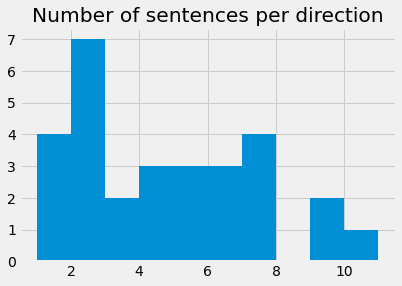

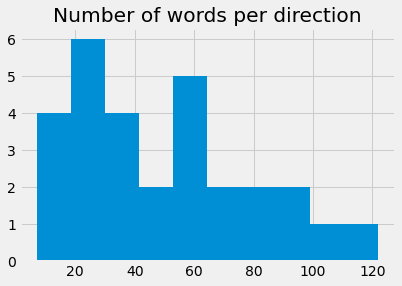

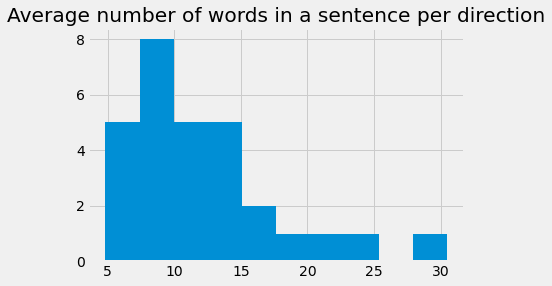

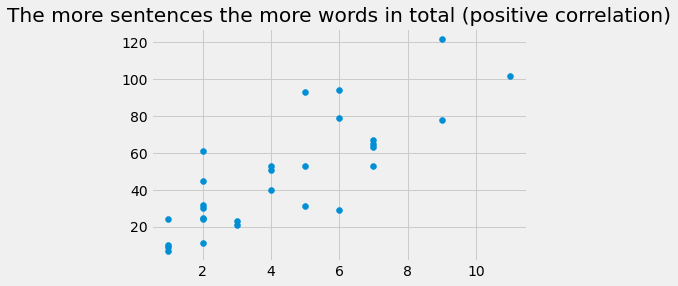

In [138]:
#number of words, sentences in directions 
processed_directions = [nlp(direction) for direction in nltk.flatten(df.directions.tolist()[:10]) if isinstance(direction, str)]
sentences_per_direction = [len(list(processed_direction.sents)) for processed_direction in processed_directions]
plt.title("Number of sentences per direction")
plt.hist(sentences_per_direction)
plt.show()

words_per_direction = [len(processed_direction) for processed_direction in processed_directions]
plt.title("Number of words per direction")
plt.hist(words_per_direction)
plt.show()

plt.title("Average number of words in a sentence per direction")
plt.hist(np.array(words_per_direction) / np.array(sentences_per_direction))
plt.show()

plt.title("The more sentences the more words in total (positive correlation)")
plt.scatter(sentences_per_direction, words_per_direction)
plt.show()

This is varying quite a lot! So there is no clue if the directions are especially long or short. Of course the correlation between #words and #sentences is positive. Interestingly it is more a cloud than a line, so some variation.